In [14]:
from scipy import io
import numpy as np
import pandas as pd

from classes.matlab_reader import matlab_reader
from classes.map_grid import map_grid

matlab = matlab_reader('AIRS_40KM_2022/20220125_AIRS_3DST-1_40km_grid.mat')
grid = map_grid()

In [25]:
temp_data = matlab.select(
    hemisphere= 'sh',
    data_field='tp',
    daytime='night',
    altitude=36)   

(501, 501)


In [26]:
class data_wizard():
    '''Colletion of functions to simplify filtering and agreggating geospatial matlab data'''
    def data_filtering(self,select_area_indexer,data):
        temp_data_select = data[select_area_indexer[:,0], select_area_indexer[:,1]]
        mask = np.full((500, 500), np.nan)
        mask[select_area_indexer[:,0], select_area_indexer[:,1]] = temp_data_select
        return mask


In [27]:
wizard = data_wizard()

select_area_indexer = grid.select_area_indexer(
    min_lat= -34,
    max_lat= -22,
    min_lon= -74,
    max_lon= -63)


In [28]:
data = wizard.data_filtering(select_area_indexer = select_area_indexer ,data = temp_data)

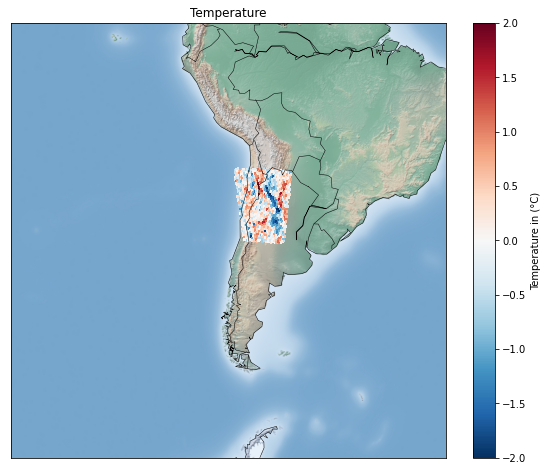

In [29]:
# matlab = matlab_reader('AIRS_40KM_2022/20220126_AIRS_3DST-1_40km_grid.mat')

# temp_data = matlab.select(
#     hemisphere= 'SH',
#     data_field='tp',
#     daytime='night',
#     altitude=36)     

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(10, 8))

m = Basemap(projection='stere', resolution='c',
            width=8E6, height=8E6, 
            lat_0=-34, lat_1=-22,
            lon_0=-74,lon_1 = -22)

m.shadedrelief(scale=0.5)

m.pcolormesh(grid.sh_lon, 
             grid.sh_lat, 
             data,
             latlon=True, cmap='RdBu_r',
             shading='auto')

m.drawcoastlines(linewidth=0.5,linestyle='solid')
m.drawcountries(linewidth=0.5, linestyle='solid',color='k')
plt.clim(-2, 2)

plt.title('Temperature')
plt.colorbar(label='Temperature in (°C)')